# Image Harmonization using Spatial-Separated Attention Modules (S2AM)

## 1. Environment Setup & Configuration

#### 1.1 Imports

In [ ]:
!pip install torchinfo > /dev/null

In [ ]:
import os
import shutil
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.models as models
from torchvision import transforms
import torchvision.transforms.functional as TF

#### 1.2 Reproductibility

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

#### 1.3 Device setup

In [ ]:
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/ImageHarmonization/HCOCO.zip"
local_path = "/content/HCOCO"

if not os.path.exists(local_path):
    if os.path.exists(zip_path):
        shutil.copy(zip_path, "/content/temp.zip")
        shutil.unpack_archive("/content/temp.zip", "/content")
        os.remove("/content/temp.zip")
        print("Data extracted successfully to /content/HCOCO")
else:
    print("Data already exists locally")

Mounted at /content/drive
Data extracted successfully to /content/HCOCO


1.4 Configuration

In [ ]:
class Config:
    DATA_ROOT = "/content"

    IMG_SIZE = 256
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 2
    NUM_WORKERS = 0

    CHECKPOINT_DIR = "checkpoints"
    RESULTS_DIR = "results"

    @staticmethod
    def setup():
        os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
        os.makedirs(Config.RESULTS_DIR, exist_ok=True)

Config.setup()

## 2. Data Pipeline & Preprocessing

#### 2.1 Augmentation

In [ ]:
class PairedAugmentor:
    def __call__(self, comp, mask, real):
        if random.random() > 0.5:
            comp = TF.hflip(comp)
            mask = TF.hflip(mask)
            real = TF.hflip(real)

        if random.random() > 0.5:
            angle = random.uniform(-10, 10)
            comp = TF.rotate(comp, angle)
            mask = TF.rotate(mask, angle)
            real = TF.rotate(real, angle)

        return comp, mask, real

#### 2.2 Dataset Definition

In [ ]:
class HarmonyDataset(Dataset):
    def __init__(self, split='train'):
        self.root = Config.DATA_ROOT
        self.size = Config.IMG_SIZE
        self.augmentor = PairedAugmentor() if split == 'train' else None

        comp_dir = os.path.join(self.root, 'composite_images')

        valid_exts = ('.jpg', '.png', '.jpeg')
        self.pairs = sorted([f for f in os.listdir(comp_dir) if f.lower().endswith(valid_exts)])

        print(f"[{split.upper()}] Dataset initialized. Found {len(self.pairs)} samples.")

        self.transform_img = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.transform_mask = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        try:
            return self.load_item(idx)
        except Exception as e:
            new_idx = random.randint(0, len(self.pairs) - 1)
            return self.__getitem__(new_idx)

    def load_item(self, idx):
        filename = self.pairs[idx]

        comp_path = os.path.join(self.root, 'composite_images', filename)

        real_candidates = []

        real_candidates.append(os.path.join(self.root, 'real_images', filename))

        name_no_ext = filename.rsplit('.', 1)[0]
        if '_' in name_no_ext:
            base_b = name_no_ext.rsplit('_', 1)[0] + ".jpg"
            real_candidates.append(os.path.join(self.root, 'real_images', base_b))

            base_c = name_no_ext.split('_')[0] + ".jpg"
            real_candidates.append(os.path.join(self.root, 'real_images', base_c))

        real_path = None
        for path in real_candidates:
            if os.path.exists(path):
                real_path = path
                break

        if real_path is None:
            raise FileNotFoundError(f"Real image not found for {filename}")

        mask_candidates = []

        if '_' in name_no_ext:
             base_clean = name_no_ext.rsplit('_', 1)[0]
             mask_candidates.append(os.path.join(self.root, 'masks', base_clean + ".png"))
             mask_candidates.append(os.path.join(self.root, 'masks', base_clean + ".jpg"))

        mask_candidates.append(os.path.join(self.root, 'masks', filename))

        mask_path = None
        for path in mask_candidates:
            if os.path.exists(path):
                mask_path = path
                break

        if mask_path is None:
            raise FileNotFoundError(f"Mask not found for {filename}")

        comp_img = Image.open(comp_path).convert('RGB')
        real_img = Image.open(real_path).convert('RGB')
        mask_img = Image.open(mask_path).convert('L')

        comp = self.transform_img(comp_img)
        real = self.transform_img(real_img)
        mask = self.transform_mask(mask_img)

        if self.augmentor:
            comp, mask, real = self.augmentor(comp, mask, real)

        return comp, mask, real

#### 2.3 Data Loaders

In [ ]:
def get_loaders():
    full_dataset = HarmonyDataset(split='train')
    total_size = len(full_dataset)

    train_size = int(0.6 * total_size)
    val_size = int(0.3 * total_size)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(
        train_set,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_set,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_set,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_loaders()
print(f"Data Loaded: {len(train_loader)} Train | {len(val_loader)} Val | {len(test_loader)} Test batches")

[TRAIN] Dataset initialized. Found 42828 samples.
Data Loaded: 1606 Train | 803 Val | 268 Test batches


## 3. Model Architectures

#### 3.1 ML Baseline



In [ ]:
class HistogramMatcher:
    def match_histograms(self, source, reference, mask):
        if source.dim() == 4:
            B = source.shape[0]
            outputs = []
            for i in range(B):
                out = self._match_single(source[i], reference[i], mask[i])
                outputs.append(out)
            return torch.stack(outputs)
        else:
            return self._match_single(source, reference, mask)

    def _match_single(self, source, reference, mask):
        src_np = ((source.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
        ref_np = ((reference.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
        mask_np = mask.permute(1, 2, 0).cpu().numpy()
        res = src_np.copy()

        for i in range(3):
            s_pixels = src_np[:, :, i][mask_np[:, :, 0] > 0.5]
            r_pixels = ref_np[:, :, i][mask_np[:, :, 0] <= 0.5]

            if len(s_pixels) == 0 or len(r_pixels) == 0:
                continue

            s_vals, _, s_counts = np.unique(s_pixels, return_inverse=True, return_counts=True)
            r_vals, r_counts = np.unique(r_pixels, return_counts=True)

            s_quantiles = np.cumsum(s_counts).astype(float) / s_pixels.size
            r_quantiles = np.cumsum(r_counts).astype(float) / r_pixels.size

            interp = np.interp(s_quantiles, r_quantiles, r_vals)
            res[:, :, i][mask_np[:, :, 0] > 0.5] = interp[_]

        res_tensor = torch.from_numpy(res).float().permute(2, 0, 1) / 255.0
        return (res_tensor - 0.5) / 0.5

#### 3.2 Deep Learning Baseline

In [ ]:
class StandardUNet(nn.Module):
    def __init__(self, out_channels=3):
        super(StandardUNet, self).__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.enc1 = resnet.layer1
        self.enc2 = resnet.layer2
        self.enc3 = resnet.layer3
        self.enc4 = resnet.layer4

        self.up4 = self._block(512, 256)
        self.up3 = self._block(256+256, 128)
        self.up2 = self._block(128+128, 64)

        self.up1 = nn.Sequential(
            nn.Conv2d(64+64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.final = nn.Sequential(
            nn.ConvTranspose2d(64+64, 32, 2, 2),
            nn.Conv2d(32, out_channels, 1),
            nn.Tanh()
        )

    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 2, 2),
            nn.Conv2d(out_c, out_c, 3, 1, 1),
            nn.ReLU(True)
        )

    def forward(self, x, mask):
        e0 = self.enc0(x)
        e1 = self.enc1(e0)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        d4 = self.up4(e4)
        d3 = self.up3(torch.cat([d4, e3], 1))
        d2 = self.up2(torch.cat([d3, e2], 1))

        d1 = self.up1(torch.cat([d2, e1], 1))

        return self.final(torch.cat([d1, e0], 1))

#### 3.3 Proposed Method (SOTA)


In [ ]:
class S2AM(nn.Module):
    def __init__(self, in_c):
        super(S2AM, self).__init__()
        self.q = nn.Conv2d(in_c, in_c // 8, 1)
        self.k = nn.Conv2d(in_c, in_c // 8, 1)
        self.v = nn.Conv2d(in_c, in_c, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, mask):
        B, C, H, W = x.size()
        m = torch.nn.functional.interpolate(mask, size=(H, W), mode='nearest')

        proj_q = self.q(x).view(B, -1, H*W).permute(0, 2, 1)
        proj_k = self.k(x).view(B, -1, H*W)
        attn = torch.softmax(torch.bmm(proj_q, proj_k), dim=-1)

        proj_v = self.v(x).view(B, -1, H*W)
        out = torch.bmm(proj_v, attn.permute(0, 2, 1)).view(B, C, H, W)

        return self.gamma * (out * m) + x

class SOTAHarmonyNet(StandardUNet):
    def __init__(self):
        super(SOTAHarmonyNet, self).__init__()
        self.attn4 = S2AM(512)
        self.attn3 = S2AM(256)
        self.attn2 = S2AM(128)
        self.attn1 = S2AM(64)

    def forward(self, x, mask):
        e0 = self.enc0(x)
        e1 = self.enc1(e0)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        d4 = self.up4(self.attn4(e4, mask))
        d3 = self.up3(torch.cat([d4, self.attn3(e3, mask)], 1))
        d2 = self.up2(torch.cat([d3, self.attn2(e2, mask)], 1))
        d1 = self.up1(torch.cat([d2, self.attn1(e1, mask)], 1))

        return self.final(torch.cat([d1, e0], 1))

#### 3.4 Model summary

In [ ]:
temp_std_model = StandardUNet()
temp_sota_model = SOTAHarmonyNet()

print("="*30)
print("Standard U-Net Summary")
print("="*30)
print(summary(temp_std_model, input_size=[(1, 3, Config.IMG_SIZE, Config.IMG_SIZE), (1, 1, Config.IMG_SIZE, Config.IMG_SIZE)]))

print("\n" + "="*30)
print("SOTA HarmonyNet Summary")
print("="*30)
print(summary(temp_sota_model, input_size=[(1, 3, Config.IMG_SIZE, Config.IMG_SIZE), (1, 1, Config.IMG_SIZE, Config.IMG_SIZE)]))

del temp_std_model
del temp_sota_model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 209MB/s]


Standard U-Net Summary
Layer (type:depth-idx)                   Output Shape              Param #
StandardUNet                             [1, 3, 256, 256]          --
├─Sequential: 1-1                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
├─Sequential: 1-2                        [1, 64, 128, 128]         --
│    └─BasicBlock: 2-4                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64,

## 4. Optimization Framework

#### 4.1 Composite Loss Function

In [ ]:
class CompositeLoss(nn.Module):
    def __init__(self):
        super(CompositeLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()

    def forward(self, pred, target, mask):
        fg_loss = self.mse(pred * mask, target * mask) * 100
        bg_loss = self.l1(pred * (1-mask), target * (1-mask)) * 10
        return fg_loss + bg_loss

#### 4.2 Harmonization Engine

In [ ]:
class HarmonizationEngine:
    def __init__(self, model, train_loader, val_loader, criterion):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optim.AdamW(self.model.parameters(), lr=Config.LEARNING_RATE)

    def fit(self):
        print(f"Initializing training for {Config.NUM_EPOCHS} epochs on {self.device}...")

        for epoch in range(Config.NUM_EPOCHS):
            self.model.train()
            train_loss = 0

            loop = tqdm(self.train_loader, leave=False, desc=f"Epoch {epoch+1}")

            for comp, mask, real in loop:

                comp = comp.to(self.device)
                mask = mask.to(self.device)
                real = real.to(self.device)

                self.optimizer.zero_grad()
                out = self.model(comp, mask)
                loss = self.criterion(out, real, mask)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                loop.set_postfix(loss=loss.item())

            val_fmse = self.validate()
            print(f"Epoch {epoch+1} | Loss: {train_loss/len(self.train_loader):.4f} | Validation fMSE: {val_fmse:.4f}")

    def validate(self):
        self.model.eval()
        total_fmse = 0
        with torch.no_grad():
            for comp, mask, real in self.val_loader:
                comp = comp.to(self.device)
                mask = mask.to(self.device)
                real = real.to(self.device)

                out = self.model(comp, mask)
                diff = (out - real) ** 2
                fmse = (diff * mask).sum() / (mask.sum() + 1e-8)
                total_fmse += fmse.item()

        return total_fmse / len(self.val_loader)

## 5. Model Training & Metric Evaluation

#### 5.1 Data Loading

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ttrain_loader, val_loader, test_loader = get_loaders()

[TRAIN] Dataset initialized. Found 42828 samples.


#### 5.2 Baseline Evaluation

In [ ]:
matcher = HistogramMatcher()
total_score = 0
count = 0

for comp, mask, real in val_loader:
    res = matcher.match_histograms(comp, real, mask)

    res = res.to(device)
    real = real.to(device)
    mask = mask.to(device)

    diff = (res - real) ** 2
    batch_mse = (diff * mask).sum() / (mask.sum() + 1e-8)

    total_score += batch_mse.item()
    count += 1

final_histogram_fmse = total_score / count
print(f"Histogram Matcher Test fMSE: {final_histogram_fmse:.4f}")

Histogram Matcher Test fMSE: 0.6296


#### 5.3 Train Standard U-Net Model

In [ ]:
std_model = StandardUNet()
std_engine = HarmonizationEngine(std_model, train_loader, val_loader, CompositeLoss())
std_engine.fit()

Initializing training for 2 epochs on cuda...


Epoch 1:   0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.8732 | Validation fMSE: 0.1389


Epoch 2:   0%|          | 0/1606 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.6174 | Validation fMSE: 0.1369


#### 5.4 Train SOTA Model

In [ ]:
Config.BATCH_SIZE = 2
Config.NUM_EPOCHS = 2

train_loader_sota, val_loader_sota, test_loader_sota = get_loaders()

sota_model = SOTAHarmonyNet()
sota_engine = HarmonizationEngine(sota_model, train_loader_sota, val_loader_sota, CompositeLoss())
sota_engine.fit()

[TRAIN] Dataset initialized. Found 42828 samples.
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 133MB/s]


Initializing training for 2 epochs on cuda...


Epoch 1:   0%|          | 0/12848 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.9595 | Validation fMSE: 0.1347


Epoch 2:   0%|          | 0/12848 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.7213 | Validation fMSE: 0.1327


#### 5.5 Final Evaluation

In [ ]:
sota_model.eval()
test_score = 0
with torch.no_grad():
    for comp, mask, real in test_loader_sota:
        comp, mask, real = comp.to(device), mask.to(device), real.to(device)
        out = sota_model(comp, mask)
        diff = (out - real) ** 2
        test_score += (diff * mask).sum() / (mask.sum() + 1e-8)

print(f"Final SOTA fMSE on test set: {test_score/len(test_loader_sota):.4f}")

Final SOTA fMSE on test set: 0.1304


## 6. Qualitative Results

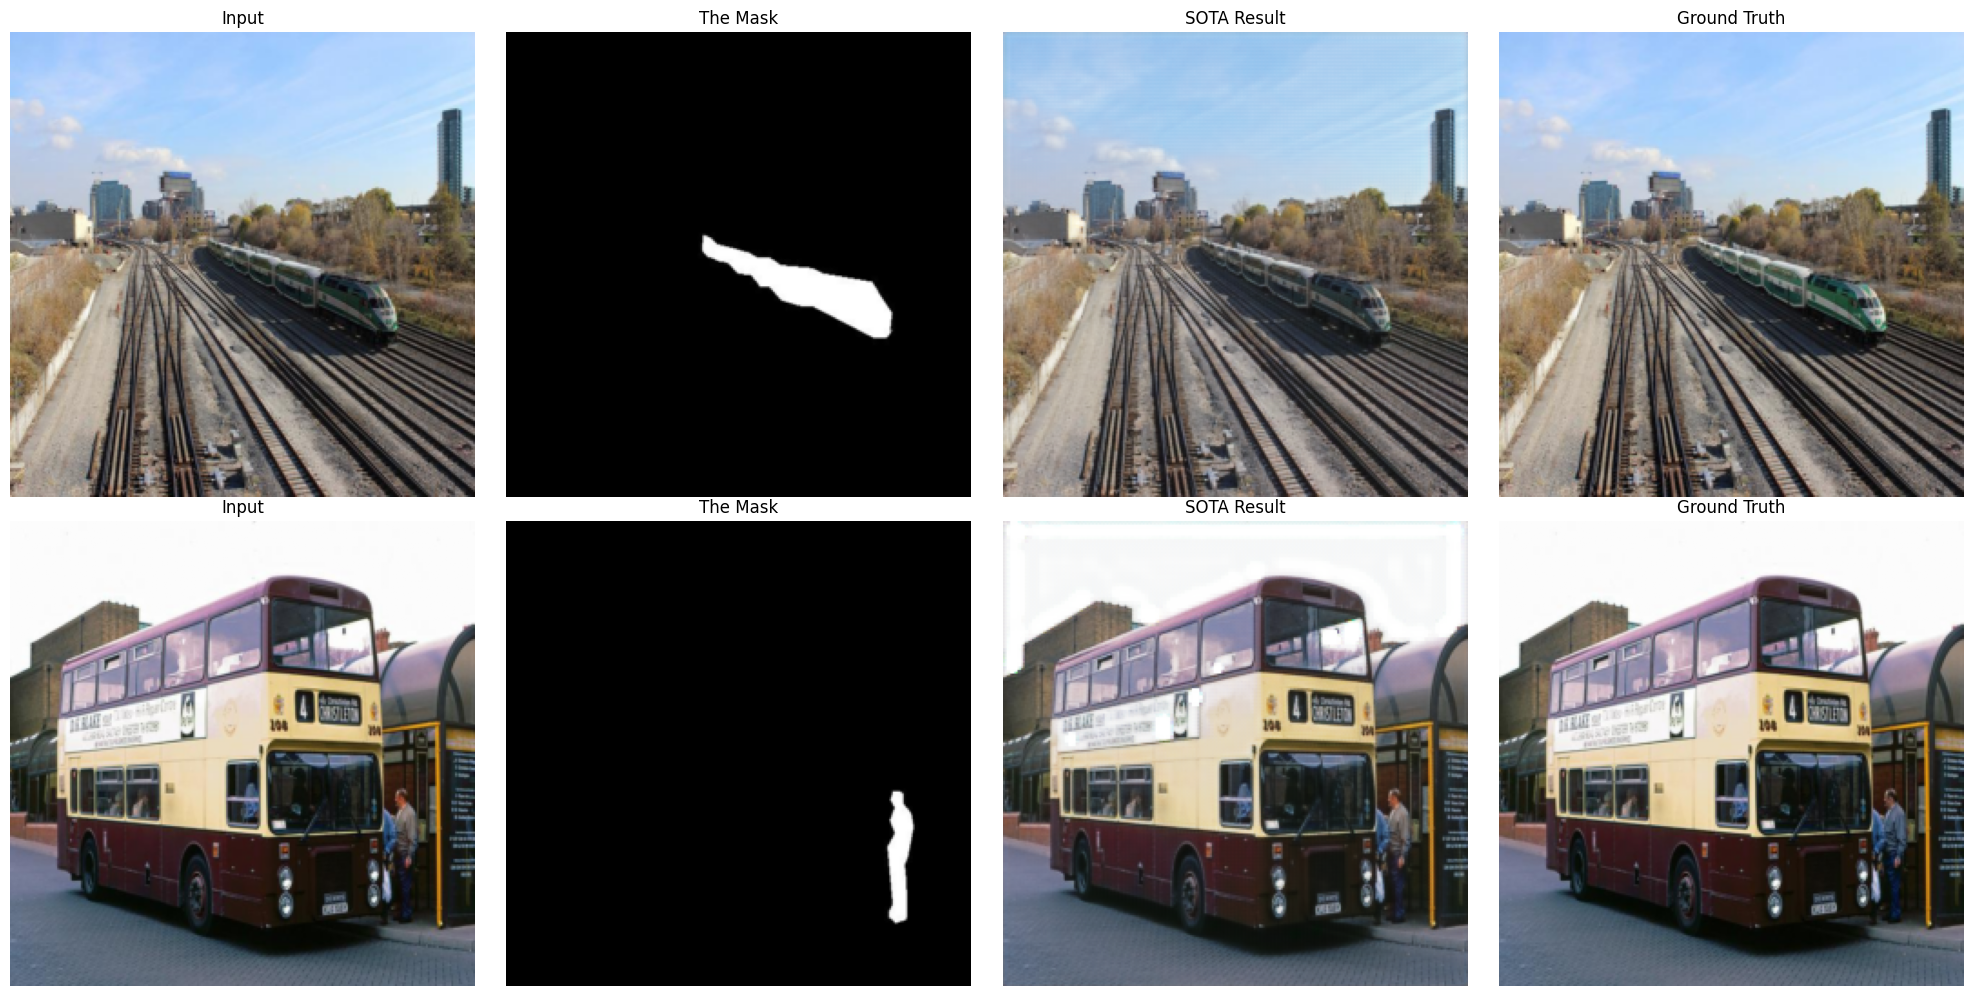

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sota_model.eval()

data_iter = iter(test_loader_sota)
for _ in range(random.randint(1, 20)):
    try:
        comp, mask, real = next(data_iter)
    except:
        data_iter = iter(test_loader_sota)
        comp, mask, real = next(data_iter)
        break

comp = comp.to(device)
mask = mask.to(device)

with torch.no_grad():
    sota_out = sota_model(comp, mask)

num_images = min(comp.shape[0], 3)
fig, ax = plt.subplots(num_images, 4, figsize=(20, 5 * num_images))

for i in range(num_images):
    def process(t):
        img = t[i].cpu().permute(1, 2, 0)
        return (img * 0.5 + 0.5).clamp(0, 1)

    if num_images == 1: ax_curr = ax
    else: ax_curr = ax[i]

    ax_curr[0].imshow(process(comp))
    ax_curr[0].set_title("Input")
    ax_curr[0].axis('off')

    mask_img = mask[i].cpu().squeeze()
    ax_curr[1].imshow(mask_img, cmap='gray')
    ax_curr[1].set_title("The Mask")
    ax_curr[1].axis('off')

    ax_curr[2].imshow(process(sota_out))
    ax_curr[2].set_title("SOTA Result")
    ax_curr[2].axis('off')

    ax_curr[3].imshow(process(real))
    ax_curr[3].set_title("Ground Truth")
    ax_curr[3].axis('off')

plt.tight_layout()
plt.show()